In [22]:
#unsupervised topic modeling and natural language processing
#for word2vec
!pip install gensim



In [4]:
!pip install scikit-plot

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

C:\Users\shashi\Documents\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
import os 

In [13]:
os.getcwd()

'C:\\Users\\shashi\\Documents'

##### Writing training text to a dataframe

In [7]:
df_train_txt = pd.read_csv('training_text', sep='\|\|', engine='python',  header=None, skiprows=1, names=["ID","Text"])
df_train_txt.head().set_index('ID')

Text
ID                                                   
0   Cyclin-dependent kinases (CDKs) regulate a var...
1    Abstract Background  Non-small cell lung canc...
2    Abstract Background  Non-small cell lung canc...
3   Recent evidence has demonstrated that acquired...
4   Oncogenic mutations in the monomeric Casitas B...

##### Writing training variants to a dataframe

In [8]:
df_train_var = pd.read_csv('training_variants')
df_train_var.head().set_index('ID')

Gene             Variation  Class
ID                                     
0   FAM58A  Truncating Mutations      1
1      CBL                 W802*      2
2      CBL                 Q249E      2
3      CBL                 N454D      3
4      CBL                 L399V      4

##### Writing test text to a dataframe

In [9]:
df_test_txt = pd.read_csv('test_text', sep='\|\|', engine='python', header=None, skiprows=1, names=["ID","Text"])
df_test_txt.head().set_index('ID')

Text
ID                                                   
0   2. This mutation resulted in a myeloproliferat...
1    Abstract The Large Tumor Suppressor 1 (LATS1)...
2   Vascular endothelial growth factor receptor (V...
3   Inflammatory myofibroblastic tumor (IMT) is a ...
4    Abstract Retinoblastoma is a pediatric retina...

##### Writing test variants to a dataframe

In [11]:
df_test_var = pd.read_csv('test_variants')
df_test_var.head().set_index('ID')

Gene Variation
ID                   
0     ACSL4     R570S
1     NAGLU     P521L
2       PAH     L333F
3      ING1     A148D
4   TMEM216      G77A

##### Merge training variants on training text

In [12]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID').fillna('')
df_train.head().set_index('ID')

Gene             Variation  Class  \
ID                                        
0   FAM58A  Truncating Mutations      1   
1      CBL                 W802*      2   
2      CBL                 Q249E      2   
3      CBL                 N454D      3   
4      CBL                 L399V      4   

                                                 Text  
ID                                                     
0   Cyclin-dependent kinases (CDKs) regulate a var...  
1    Abstract Background  Non-small cell lung canc...  
2    Abstract Background  Non-small cell lung canc...  
3   Recent evidence has demonstrated that acquired...  
4   Oncogenic mutations in the monomeric Casitas B...

##### Merge test variants on test text

In [13]:
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID').fillna('')
df_test.head().set_index('ID')

Gene Variation                                               Text
ID                                                                      
0     ACSL4     R570S  2. This mutation resulted in a myeloproliferat...
1     NAGLU     P521L   Abstract The Large Tumor Suppressor 1 (LATS1)...
2       PAH     L333F  Vascular endothelial growth factor receptor (V...
3      ING1     A148D  Inflammatory myofibroblastic tumor (IMT) is a ...
4   TMEM216      G77A   Abstract Retinoblastoma is a pediatric retina...

In [14]:
df_train.describe(include='all')

ID   Gene             Variation        Class  \
count   3321.000000   3321                  3321  3321.000000   
unique          NaN    264                  2996          NaN   
top             NaN  BRCA1  Truncating Mutations          NaN   
freq            NaN    264                    93          NaN   
mean    1660.000000    NaN                   NaN     4.365854   
std      958.834449    NaN                   NaN     2.309781   
min        0.000000    NaN                   NaN     1.000000   
25%      830.000000    NaN                   NaN     2.000000   
50%     1660.000000    NaN                   NaN     4.000000   
75%     2490.000000    NaN                   NaN     7.000000   
max     3320.000000    NaN                   NaN     9.000000   

                                                     Text  
count                                                3321  
unique                                               1921  
top     The PTEN (phosphatase and tensin homolog) phos...  
freq                                                   53  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

In [15]:
df_test.describe(include='all')

ID  Gene             Variation  \
count   5668.000000  5668                  5668   
unique          NaN  1397                  5628   
top             NaN    F8  Truncating Mutations   
freq            NaN   134                    18   
mean    2833.500000   NaN                   NaN   
std     1636.354994   NaN                   NaN   
min        0.000000   NaN                   NaN   
25%     1416.750000   NaN                   NaN   
50%     2833.500000   NaN                   NaN   
75%     4250.250000   NaN                   NaN   
max     5667.000000   NaN                   NaN   

                                                     Text  
count                                                5668  
unique                                               5611  
top     The PTEN (phosphatase and tensin homolog) phos...  
freq                                                    6  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

##### Plot the value count for each class

<AxesSubplot:>

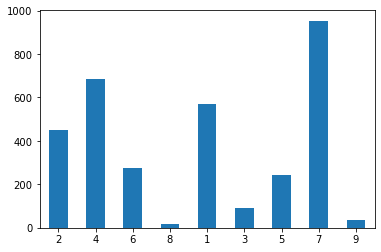

In [16]:
df_train['Class'].value_counts(sort=False).plot(kind="bar", rot=0)

##### Define a Logistic regression function

In [17]:
def evaluate_features(X, y, clf=None):
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

In [18]:
#from sklearn.datasets import load_iris
#evaluate_features(*load_iris(True))

# we don't need this accuracy test

##### Bag of Words

In [37]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)   

In [41]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shashi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [42]:
bag_of_words = count_vectorizer.fit_transform(df_train['Text'])

In [43]:
len(count_vectorizer.get_feature_names())

279098

In [44]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

In [46]:
evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel())

C:\Users\shashi\Documents\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished
C:\Users\shashi\Documents\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 2.0595794153065827
Accuracy: 0.3833182776272207


C:\Users\shashi\Documents\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.4s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
C:\Users\shashi\Documents\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.6083731110360213
Accuracy: 0.40680517916290276


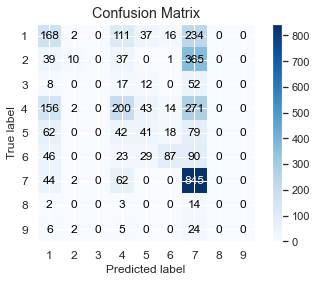

In [47]:
evaluate_features(truncated_bag_of_words, df_train['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

##### TFIDF

In [48]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(df_train['Text'])

len(count_vectorizer.get_feature_names())

279098

In [49]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

C:\Users\shashi\Documents\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
C:\Users\shashi\Documents\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.633332375616898
Accuracy: 0.4101174345076784


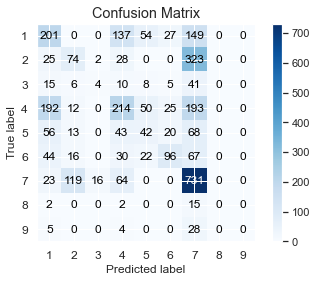

In [50]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel())

C:\Users\shashi\Documents\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
C:\Users\shashi\Documents\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.5650584413929207
Accuracy: 0.41945197229750075


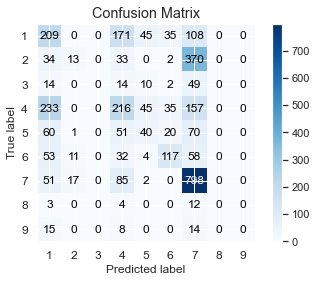

In [51]:
evaluate_features(truncated_tfidf, df_train['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

##### Word2Vec

In [20]:
class MySentences(object):
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)
                    
def get_word2vec(sentences, location):
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [21]:
w2vec = get_word2vec(
    MySentences(
        df_train['Text'].values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

w2vmodel not found. training model
Model done training. Saving to disk
